##### Copyright 2019 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.


# 추정기(Estimator)로 선형 모델 만들기

<table class="tfo-notebook-buttons" align="left">
  <td><a target="_blank" href="https://www.tensorflow.org/tutorials/estimator/linear"><img src="https://www.tensorflow.org/images/tf_logo_32px.png"><img> TensorFlow.org에서 보기</a></td>
  <td><a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs-l10n/blob/master/site/ko/tutorials/estimator/linear.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png">Google Colab에서 실행하기</a></td>
  <td><a target="_blank" href="https://github.com/tensorflow/docs-l10n/blob/master/site/ko/tutorials/estimator/linear.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png">GitHub에서 소스 보기</a></td>
  <td><a href="https://storage.googleapis.com/tensorflow_docs/docs-l10n/site/ko/tutorials/estimator/linear.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png">노트북 다운로드하기</a></td>
</table>

> 경고: Estimator는 새 코드에 권장되지 않습니다. Estimator는 `v1.Session` 스타일 코드를 실행하며, 이 코드는 올바르게 작성하기가 좀 더 어렵고 특히 TF 2 코드와 결합할 경우 예기치 않게 작동할 수 있습니다. Estimator는 [호환성 보장](https://tensorflow.org/guide/versions)이 적용되지만 보안 취약점 외에는 수정 사항이 제공되지 않습니다. 자세한 내용은 [마이그레이션 가이드](https://tensorflow.org/guide/migrate)를 참조하세요.

## 개요

Note: 이 문서는 텐서플로 커뮤니티에서 번역했습니다. 커뮤니티 번역 활동의 특성상 정확한 번역과 최신 내용을 반영하기 위해 노력함에도 불구하고 [공식 영문 문서](https://www.tensorflow.org/?hl=en)의 내용과 일치하지 않을 수 있습니다. 이 번역에 개선할 부분이 있다면 [tensorflow/docs-l10n](https://github.com/tensorflow/docs-l10n/) 깃헙 저장소로 풀 리퀘스트를 보내주시기 바랍니다. 문서 번역이나 리뷰에 참여하려면 [docs-ko@tensorflow.org](https://groups.google.com/a/tensorflow.org/forum/#!forum/docs-ko)로 메일을 보내주시기 바랍니다.

참고: Keras 로지스틱 회귀 예제를 [사용할 수](https://tensorflow.org/guide/migrate/tutorials/keras/regression) 있으며 이 튜토리얼보다 권장됩니다.


## 설정

In [2]:
!pip install sklearn


  Preparing metadata (setup.py) ... -

 done


 done
  Created wheel for sklearn: filename=sklearn-0.0.post1-py3-none-any.whl size=2935 sha256=27d86ea05ec407f5bede7b71fde558d0ed57ae3e4ea2c01e40f51cc339c58c5e
  Stored in directory: /home/kbuilder/.cache/pip/wheels/03/8b/6f/9f13c705de81a6b351b718b3cf917e41ad7c0933c8630d4dd4
Successfully built sklearn


In [3]:
import os
import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import clear_output
from six.moves import urllib

## 타이타닉 데이터셋을 불러오기

타이타닉 데이터셋을 사용할 것입니다. 성별, 나이, 클래스, 기타 등 주어진 정보를 활용하여 승객이 살아남을 것인지 예측하는 것을 목표로 합니다.

In [4]:
import tensorflow.compat.v2.feature_column as fc

import tensorflow as tf

2022-12-14 22:33:29.380734: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-12-14 22:33:29.380865: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2022-12-14 22:33:29.380876: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.


In [5]:
# Load dataset.
dftrain = pd.read_csv('https://storage.googleapis.com/tf-datasets/titanic/train.csv')
dfeval = pd.read_csv('https://storage.googleapis.com/tf-datasets/titanic/eval.csv')
y_train = dftrain.pop('survived')
y_eval = dfeval.pop('survived')

## 데이터 탐험하기

데이터셋은 다음의 특성을 가집니다

In [6]:
dftrain.head()

,sex,age,n_siblings_spouses,parch,fare,class,deck,embark_town,alone
0,male,22.0,1,0,7.2500,Third,unknown,Southampton,n
1,female,38.0,1,0,71.2833,First,C,Cherbourg,n
2,female,26.0,0,0,7.9250,Third,unknown,Southampton,y
3,female,35.0,1,0,53.1000,First,C,Southampton,n
4,male,28.0,0,0,8.4583,Third,unknown,Queenstown,y


In [7]:
dftrain.describe()

,age,n_siblings_spouses,parch,fare
count,627.000000,627.000000,627.000000,627.000000
mean,29.631308,0.545455,0.379585,34.385399
std,12.511818,1.151090,0.792999,54.597730
min,0.750000,0.000000,0.000000,0.000000
25%,23.000000,0.000000,0.000000,7.895800
50%,28.000000,0.000000,0.000000,15.045800
75%,35.000000,1.000000,0.000000,31.387500
max,80.000000,8.000000,5.000000,512.329200


훈련셋은 627개의 샘플로 평가셋은 264개의 샘플로 구성되어 있습니다.

In [8]:
dftrain.shape[0], dfeval.shape[0]

(627, 264)

대부분의 승객은 20대와 30대 입니다.

<AxesSubplot: >

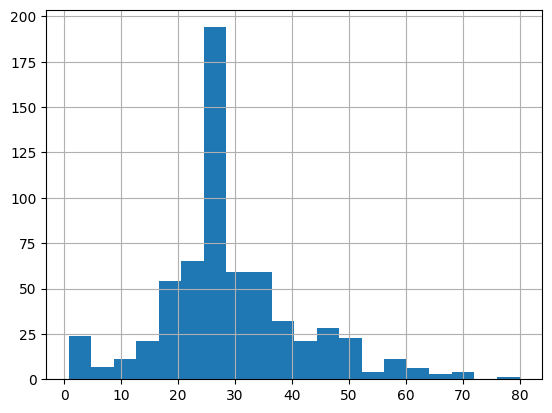

In [9]:
dftrain.age.hist(bins=20)

남자 승객이 여자 승객보다 대략 2배 많습니다.

<AxesSubplot: >

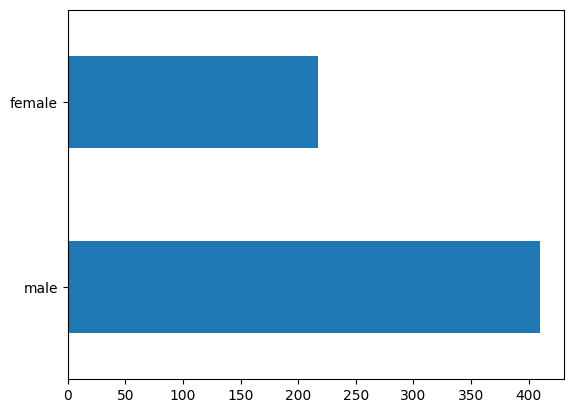

In [10]:
dftrain.sex.value_counts().plot(kind='barh')

대부분의 승객은 "삼등석" 입니다.

<AxesSubplot: >

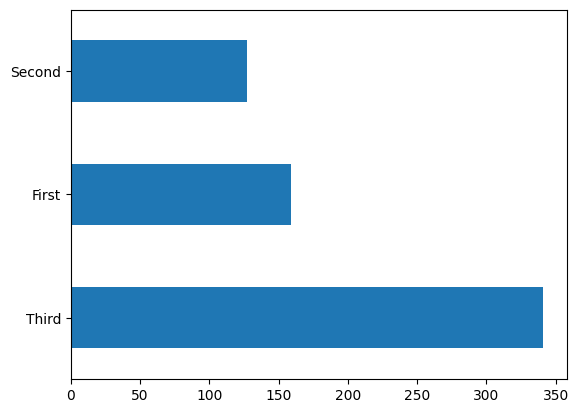

In [11]:
dftrain['class'].value_counts().plot(kind='barh')

여자는 남자보다 살아남을 확률이 훨씬 높습니다. 이는 명확하게 모델에 유용한 특성입니다.

Text(0.5, 0, '% survive')

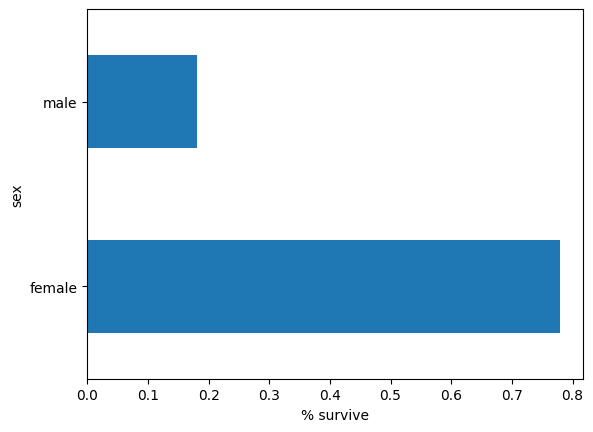

In [12]:
pd.concat([dftrain, y_train], axis=1).groupby('sex').survived.mean().plot(kind='barh').set_xlabel('% survive')

## 모델의 특성 엔지니어링

> 경고: 이 튜토리얼에 설명된 <code>tf.feature_columns</code> 모듈은 새 코드에는 권장되지 않습니다. [Keras 전처리 레이어](https://tensorflow.org/guide/versions)에서 이 기능을 다룹니다. 마이그레이션 지침은 <a>마이그레이션 특성 열</a> 가이드를 참조하세요. <code>tf.feature_columns</code> 모듈은 TF1 <code>Estimators</code>와 함께 사용하도록 설계되었습니다. 이는 우리의 <a>호환성 보장</a> 대상에 해당하지만 보안 취약점 외에는 수정 사항이 제공되지 않습니다.

추정기는 [특성 열](https://www.tensorflow.org/tutorials/structured_data/feature_columns)이라는 시스템을 사용하여 모델이 각 원시 입력 특성을 해석하는 방식을 설명합니다. 추정기는 숫자 입력의 벡터를 예상하고 *특성 열*은 모델이 각 특성을 변환하는 방식을 설명합니다.

효과적인 모델 학습에서는 적절한 특성 열을 고르고 다듬는 것이 키포인트 입니다. 하나의 특성 열은 특성 딕셔너리(dict)의 원본 입력으로 만들어진 열(*기본 특성 열*)이거나 하나 이상의 기본 열(*얻어진 특성 열*)에 정의된 변환을 이용하여 새로 생성된 열입니다.

선형 추정기는 수치형, 범주형 특성을 모두 사용할 수 있습니다. 특성 열은 모든 텐서플로 추정기와 함께 작동하고 목적은 모델링에 사용되는 특성들을 정의하는 것입니다. 또한 원-핫-인코딩(one-hot-encoding), 정규화(normalization), 버킷화(bucketization)와 같은 특성 공학 방법을 지원합니다.

### 기본 특성 열

In [13]:
CATEGORICAL_COLUMNS = ['sex', 'n_siblings_spouses', 'parch', 'class', 'deck',
                       'embark_town', 'alone']
NUMERIC_COLUMNS = ['age', 'fare']

feature_columns = []
for feature_name in CATEGORICAL_COLUMNS:
  vocabulary = dftrain[feature_name].unique()
  feature_columns.append(tf.feature_column.categorical_column_with_vocabulary_list(feature_name, vocabulary))

for feature_name in NUMERIC_COLUMNS:
  feature_columns.append(tf.feature_column.numeric_column(feature_name, dtype=tf.float32))

`input_function`은 입력 파이프라인을 스트리밍으로 공급하는 `tf.data.Dataset`으로 데이터를 변환하는 방법을 명시합니다. `tf.data.Dataset`은 데이터 프레임, CSV 형식 파일 등과 같은 여러 소스를 사용합니다.

In [14]:
def make_input_fn(data_df, label_df, num_epochs=10, shuffle=True, batch_size=32):
  def input_function():
    ds = tf.data.Dataset.from_tensor_slices((dict(data_df), label_df))
    if shuffle:
      ds = ds.shuffle(1000)
    ds = ds.batch(batch_size).repeat(num_epochs)
    return ds
  return input_function

train_input_fn = make_input_fn(dftrain, y_train)
eval_input_fn = make_input_fn(dfeval, y_eval, num_epochs=1, shuffle=False)

다음과 같이 데이터셋을 점검할 수 있습니다:

In [15]:
ds = make_input_fn(dftrain, y_train, batch_size=10)()
for feature_batch, label_batch in ds.take(1):
  print('Some feature keys:', list(feature_batch.keys()))
  print()
  print('A batch of class:', feature_batch['class'].numpy())
  print()
  print('A batch of Labels:', label_batch.numpy())

Some feature keys: ['sex', 'age', 'n_siblings_spouses', 'parch', 'fare', 'class', 'deck', 'embark_town', 'alone']

A batch of class: [b'Third' b'Third' b'First' b'Third' b'Third' b'Third' b'First' b'Third'
 b'Second' b'First']

A batch of Labels: [0 0 1 0 1 0 0 0 1 1]


또한 `tf.keras.layers.DenseFeatures` 층을 사용하여 특정한 특성 열의 결과를 점검할 수 있습니다:

In [16]:
age_column = feature_columns[7]
tf.keras.layers.DenseFeatures([age_column])(feature_batch).numpy()

array([[29.],
       [51.],
       [28.],
       [30.],
       [ 4.],
       [ 4.],
       [31.],
       [30.],
       [21.],
       [58.]], dtype=float32)

`DenseFeatures`는 조밀한(dense) 텐서만 허용합니다. 범주형 데이터를 점검하려면 우선 범주형 열에 indicator_column 함수를 적용해야 합니다:

In [17]:
gender_column = feature_columns[0]
tf.keras.layers.DenseFeatures([tf.feature_column.indicator_column(gender_column)])(feature_batch).numpy()

array([[0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.]], dtype=float32)

모든 기본 특성을 모델에 추가한 다음에 모델을 훈련해 봅시다. 모델을 훈련하려면 `tf.estimator` API를 이용한 메서드 호출 한번이면 충분합니다:

In [18]:
linear_est = tf.estimator.LinearClassifier(feature_columns=feature_columns)
linear_est.train(train_input_fn)
result = linear_est.evaluate(eval_input_fn)

clear_output()
print(result)

{'accuracy': 0.7462121, 'accuracy_baseline': 0.625, 'auc': 0.8314049, 'auc_precision_recall': 0.7929586, 'average_loss': 0.4918203, 'label/mean': 0.375, 'loss': 0.48571348, 'precision': 0.64285713, 'prediction/mean': 0.4394845, 'recall': 0.72727275, 'global_step': 200}


### 도출된 특성 열

이제 정확도 75%에 도달했습니다. 별도로 각 기본 특성 열을 사용하면 데이터를 설명하기에는 충분치 않을 수 있습니다. 예를 들면, 성별과 레이블간의 상관관계는 성별에 따라 다를 수 있습니다. 따라서 `gender="Male"`과 'gender="Female"`의 단일 모델가중치만 배우면 모든 나이-성별 조합(이를테면 `gender="Male" 그리고 'age="30"`그리고`gender="Male"`그리고`age="40"`을 구별하는 것)을 포함시킬 수 없습니다.

서로 다른 특성 조합들 간의 차이를 학습하기 위해서 모델에 *교차 특성 열*을 추가할 수 있습니다(또한 교차 열 이전에 나이 열을 버킷화할 수 있습니다):

In [19]:
age_x_gender = tf.feature_column.crossed_column(['age', 'sex'], hash_bucket_size=100)

조합 특성을 모델에 추가하고 모델을 다시 훈련합니다:

In [20]:
derived_feature_columns = [age_x_gender]
linear_est = tf.estimator.LinearClassifier(feature_columns=feature_columns+derived_feature_columns)
linear_est.train(train_input_fn)
result = linear_est.evaluate(eval_input_fn)

clear_output()
print(result)

{'accuracy': 0.7537879, 'accuracy_baseline': 0.625, 'auc': 0.84459746, 'auc_precision_recall': 0.79323035, 'average_loss': 0.4729848, 'label/mean': 0.375, 'loss': 0.46476856, 'precision': 0.6666667, 'prediction/mean': 0.41475508, 'recall': 0.68686867, 'global_step': 200}


이제 정확도 77.6%에 도달했습니다. 기본 특성만 이용한 학습보다는 약간 더 좋았습니다. 더 많은 특성과 변환을 사용해서 더 잘할 수 있다는 것을 보여주세요!

이제 훈련 모델을 이용해서 평가셋에서 승객에 대해 예측을 할 수 있습니다. 텐서플로 모델은 한번에 샘플의 배치 또는 일부에 대한 예측을 하도록 최적화되어있습니다. 앞서, `eval_input_fn`은 모든 평가셋을 사용하도록 정의되어 있었습니다.

INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmpfs/tmp/tmps9yhceth/model.ckpt-200


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


<AxesSubplot: title={'center': 'predicted probabilities'}, ylabel='Frequency'>

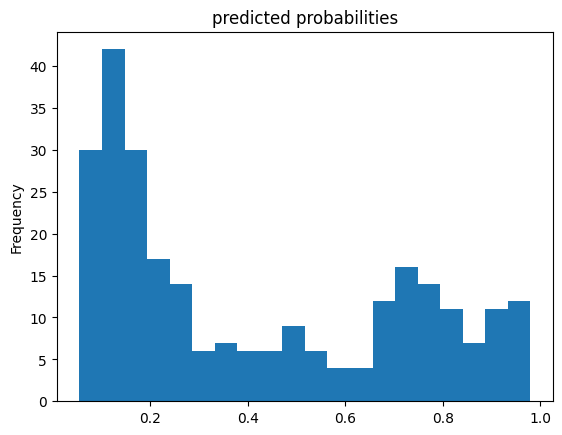

In [21]:
pred_dicts = list(linear_est.predict(eval_input_fn))
probs = pd.Series([pred['probabilities'][1] for pred in pred_dicts])

probs.plot(kind='hist', bins=20, title='predicted probabilities')

마지막으로, 수신자 조작 특성(receiver operating characteristic, ROC)을 살펴보면 정탐률(true positive rate)과 오탐률(false positive rate)의 상충관계에 대해 더 잘 이해할 수 있습니다.

(0.0, 1.05)

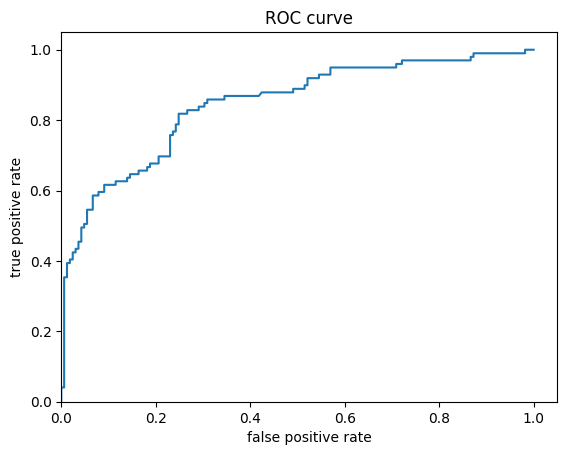

In [22]:
from sklearn.metrics import roc_curve
from matplotlib import pyplot as plt

fpr, tpr, _ = roc_curve(y_eval, probs)
plt.plot(fpr, tpr)
plt.title('ROC curve')
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.xlim(0,)
plt.ylim(0,)